# 基盤データサイエンス演習 第5回

※本演習資料の二次配布・再配布はお断り致します。

　今回の演習の内容は以下の2つである。

　**DS5.0 | データセットの準備**

　**DS5.1 | 階層的クラスタリング (Hierarchical clustering)**

　**DS5.2 | K-meansクラスタリング (K-means clustering)**

　クラスタリングには多数のアルゴリズムがあるが、今回は比較的理解しやすい階層的クラスタリングとK-meansクラスタリングを扱う。


---
## DS5.0 データセットの準備

　今回は性質の異なる二つのデータセットを取り扱う。一つはGaussianデータセットで、中心と分散の異なる正規分布からそれぞれのクラスタが生成される。もう一つはmoonデータセットで、それぞれのクラスタが三日月型をしており、それらを組み合わせた形状をしている。

　下のセルがGaussianデータセットを生成する関数である。`centers`に正規分布の中心のリスト、`stds`に標準偏差のリスト、`sizes`にデータ数のリストをとる。

In [1]:
# dataset generation
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

def gen_2d_gaussian(centers, stds, sizes, random_state=0):
  # generate data based on 2D-gaussian
  np.random.seed(random_state)

  clusters = []
  labels = []
  # for each cluster
  for i in range(len(sizes)):
    clusters.append(normal(centers[i], stds[i], size=(sizes[i], 2)))
    labels.extend([i]*sizes[i])
  ret = np.concatenate(clusters, axis=0) 
  return ret, np.array(labels)
  
# default parameter: gen_2d_gaussian([(0, 0), (5, 0)], [0.75, 1.25], [100, 300])
data_gaussian, labels_gaussian = gen_2d_gaussian([(0, 0), (5, 0)], [0.75, 1.25], [100, 300])

　moonデータセットはscikit-learnに用意されている関数を用いて生成する。

In [2]:
from sklearn.datasets import make_moons
data_moon, labels_moon = make_moons(n_samples=300, noise=0.05, random_state=0)

　作成したデータセットを見てみよう。`plot_clustering`はクラスタリングした結果をプロットする関数である。`cluster_labels`が各データがどのクラスタに属しているかの情報で、これを基にデータの色を決定している。

　ここではデータセットを生成した際のクラスタ番号（真のラベル）を用いている。

In [3]:
# function for plot cluster by color
def plot_clustering(data, cluster_labels, n_clusters=2, title=None):

  plt.figure(figsize=(6, 6))
  cmap = plt.get_cmap('gist_rainbow')
  for i in range(n_clusters):
    plt.scatter(data[cluster_labels==i, 0], data[cluster_labels==i, 1],
                color=cmap(i/n_clusters))

  plt.axis('equal') # make figure square (1:1 aspect ratio)
  if title is not None:
    plt.title(title)
  plt.show()

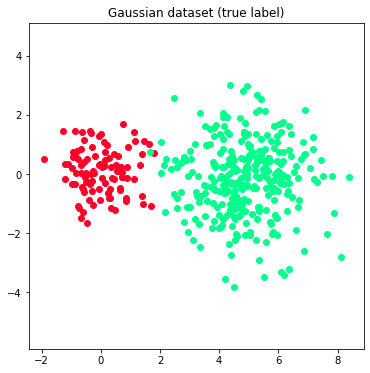

In [4]:
plot_clustering(data_gaussian, labels_gaussian, title="Gaussian dataset (true label)")

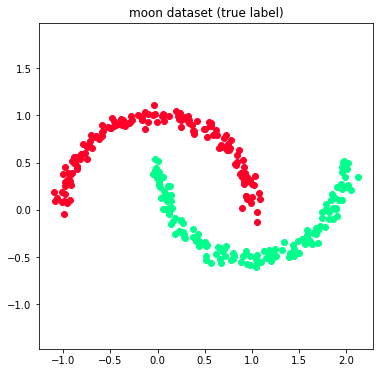

In [5]:
plot_clustering(data_moon, labels_moon, title="moon dataset (true label)")

　なお、今回はデータがどのクラスタに属しているかを事前に知っているが、実際のデータセットではデータがどのクラスタに属しているかが未知（教師なし）であることに注意せよ。

---
## DS5.1 | 階層的クラスタリング (Hierarchical clustering)

　クラスタリングとは、データをその特徴だけを用いて複数のグループ（クラスタ）に分割する手法のことである。同一クラスタに属するデータは互いに類似しており、異なるクラスタに属するデータは互いに類似していないことが望ましい。

　階層的クラスタリングには2種類の手法があり、**トップダウン（分割型; divisive hierarchical clustering）**と**ボトムアップ（凝集型; agglomerative hierarchical clustering）**である。
トップダウン手法では、決定木のように、すべてのデータが含まれる一つのクラスタを初期状態とし、最もよくデータを分割できる分割でクラスタを二つに分けることを繰り返してクラスタリングを行う。
ボトムアップ手法では、すべてのデータが互いに異なるクラスタに属する状態を初期状態とし、クラスタ同士の距離が最も近いペアを一つにまとめる処理を繰り返してクラスタリングを行う。

　このうち、単純な実装において計算コストの面で優れているのはボトムアップ法である。直感的な理由としては、データ数を$N$としたときトップダウン法の最初の分割の仕方はおよそ$2^N$通りあるのに対し、ボトムアップ法での最初のクラスタのまとめ方はおよそ$N^2$通りだからである。ここでは、ボトムアップ法について、実際にコードを実行してみる。

　次のセルが実際にクラスタリングを行う部分である。クラスタ間の類似度を判定する方法が`linkage`で定義されている。`linkage`は

　`"ward", "complete", "average", "single"`

から選ぶことができる。これらの手法の詳細は講義の資料を参照せよ。なお、scikit-learnのデフォルトでは一般的によく用いられるWard法 (`"ward"`) が用いられている。

Number of cluster members: (282, 118)


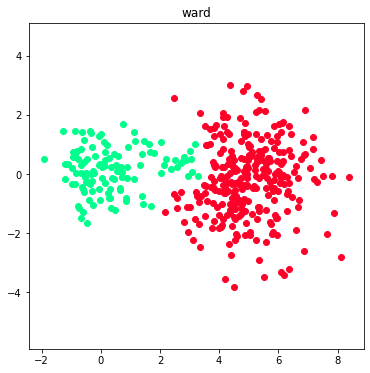

In [6]:
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

n_clusters = 2
method = "ward" # CHANGE HERE

# do clustering
clustering = AgglomerativeClustering(linkage=method, n_clusters=n_clusters)
clustering.fit(data_gaussian)

# print number of cluster members
member_0 = np.count_nonzero(clustering.labels_==0)
member_1 = np.count_nonzero(clustering.labels_==1)
print(f"Number of cluster members: ({member_0}, {member_1})")

plot_clustering(data_gaussian, clustering.labels_, 
                n_clusters=n_clusters, title=f"{method}")


　階層型クラスタリングの場合、**どのようにボトムアップでクラスタが形成されたか**を**樹形図 (dendrogram)** で確認することができる。

　樹形図を描画したい場合、 `sklearn.cluster.AgglomerativeClustering()` を用いるより、 `scipy` という別のライブラリを用いた方が良いので、こちらを利用する。（補足資料 ※1）

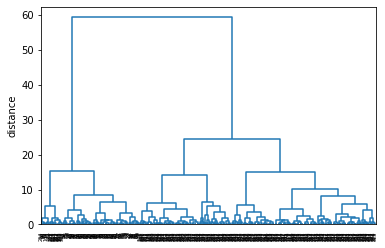

In [7]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

Z = hierarchy.linkage(data_gaussian, method=method)
hierarchy.dendrogram(Z, color_threshold=0)
plt.ylabel("distance")
plt.show()

　階層型クラスタリングによって、「2つのクラスタに分ける」とは、**樹形図を2つの（より小さな）樹形図になるように横向きに**（＝あるdistanceの閾値を決めて）**はさみを入れることと同値**である。

---
##### 課題 DS5.1
　Gaussianデータセットについて、クラスタ間の類似度を判定する手法`linkage`を変化させて実行し、
 * データをうまくクラスタリングできている手法とできていない手法をそれぞれ一つ選び、
 * またその理由について考察せよ。


---
##### 課題 DS5.2

　moonデータセットについて、クラスタ間の類似度を判定する手法`linkage`を変化させて実行し、
 * データをうまくクラスタリングできている手法とできていない手法をそれぞれ一つ選び、
 * またその理由について考察せよ。


---
## DS5.2 | K-meansクラスタリング (K-means clustering)

　**K-meansクラスタリング** は、以下のようなアルゴリズムでクラスタを決定する手法である。

1. ランダムに**k**個のクラスタの中心となる点を選ぶ。
2. 各データを中心が最も近いクラスタに属させる。
3. クラスタの中心を、そのクラスタに属するデータの平均 (**mean**) に更新する。
4. 2〜3を収束するまで繰り返す。

　K-meansクラスタリングは、
 * 初期状態をランダムに選び、初期値に依存して結果が変化する
 * 最終的に、各データはクラスタの中心にもっとも近いクラスタに属する
 
といった性質をもち、クラスタ間の境界は直線もしくは（超）平面となる。
 
　実際にK-meansクラスタリングを行ってみよう。

In [ ]:
from sklearn.cluster import KMeans

kmeans_random_seed = 0
kmeans = KMeans(random_state=kmeans_random_seed, n_clusters=2)
kmeans.fit(data_gaussian)

# print number of cluster members
member_0 = np.count_nonzero(kmeans.labels_==0)
member_1 = np.count_nonzero(kmeans.labels_==1)
print(f"Number of cluster members: ({member_0}, {member_1})")

plot_clustering(data_gaussian, kmeans.labels_, n_clusters=2, title="kmeans")
plt.show()

　次に、`KMeans`ライブラリを用いずに1ステップずつK-meansクラスタリングを実行し、実際にどのようにクラスタリングが行われるか見てみよう。ここで★はそれぞれの重心を表しており、直線がクラスタ境界を表している。

In [10]:
def means_of_clusters(data, labels, n_clusters=2):
  # return means of clusters
  ret = []
  for i in range(n_clusters):
    ret.append(np.mean(data[labels==i], axis=0))
  return np.array(ret)

In [11]:
def belong_cluster(data, means):
  # return nearest cluster label for each data point
  labels = []

  # iterate by row (each data)
  for data_point in data:
    dists = []
    # iterate by row (each cluster)
    for cluster_center in means:
      dist = np.linalg.norm(data_point-cluster_center)
      dists.append(dist)

    nearest_cluster = np.argmin(dists)
    labels.append(nearest_cluster)
  return np.array(labels)

In [12]:
def plot_kmeans(data, means, cluster_labels, ax, title=None):
  # plot K-means clustering 
  # only for 2 classes, because of cluster boundary implementation
  colors = ["blue", "red"]
  n_clusters = 2
  for i in range(n_clusters):
    # plot each cluster's data points
    ax.scatter(data[cluster_labels==i, 0], data[cluster_labels==i, 1],
                color=colors[i], s=16, alpha=0.7)
    # plot each cluster's mean
    ax.scatter([means[i, 0]], [means[i, 1]], marker="*",
                color="k", s=92)

  # plot cluster boundary (vertical bisector of cluster means)
  center = np.mean(means, axis=0)
  diff = means[1]-means[0]
  ortho_grad = np.array([-diff[1], diff[0]]) / np.linalg.norm(diff) 
  ax.plot([center[0]-ortho_grad[0]*4, center[0]+ortho_grad[0]*4],
          [center[1]-ortho_grad[1]*4, center[1]+ortho_grad[1]*4])
  
  # set graph appearance
  plt.tight_layout()
  ax.set_xlim([-3, 9])
  ax.set_ylim([-6, 6])
  ax.axis('equal')
  if title is not None:
    plt.title(title)


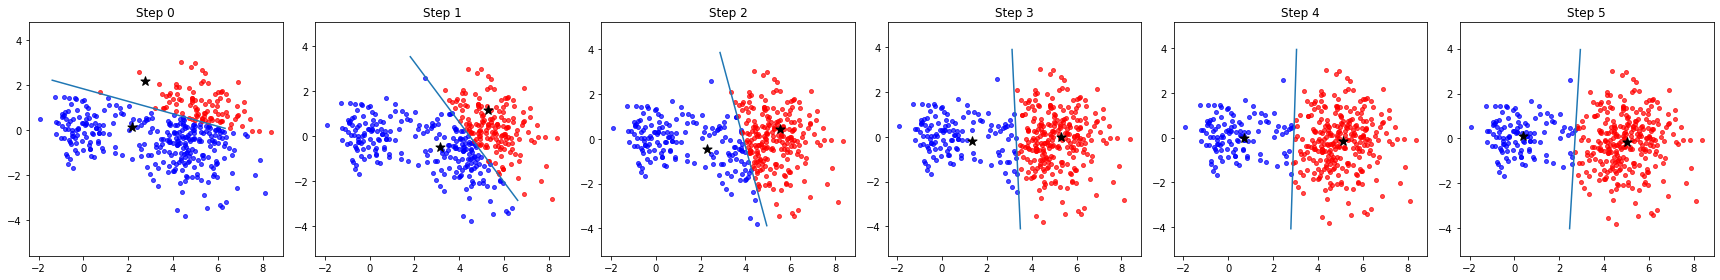

In [13]:
# clustering parameter
n_clusters = 2
initial_range = 5
n_iter = 6

fig = plt.figure(figsize=(4*n_iter, 4))

kmeans_random_seed = 2 # kmeans random seed

# randomly choose initial cluster means
np.random.seed(kmeans_random_seed)
means = np.random.rand(n_clusters, 2)*initial_range

for i in range(n_iter):
  # belong datapoints to new cluster
  kmeans_labels = belong_cluster(data_gaussian, means)

  # Add i-th figure (1-origin)
  ax = fig.add_subplot(1, n_iter, i+1)
  # Pass the figure to plot function
  plot_kmeans(data_gaussian, means, kmeans_labels, ax,
              title=f"Step {i}")

  # calculate new means
  means = means_of_clusters(data_gaussian, kmeans_labels, n_clusters)

---
##### 課題 DS5.3
　先に述べたように、K-meansクラスタリングは、ランダムに選んだ初期状態に依存して結果が変化する。

　初期値 (`kmeans_random_seed`) を変化させ、結果がどのようになるか図を示しながら考察せよ。
例えば、どのような領域がランダムな要素に影響されやすく、どのような領域はされにくいだろうか。

---
##### 課題 DS5.4

　三日月型データ (moon) をK-meansクラスタリング（クラスタ数は2とする）でクラスタリングするとどうなるだろうか。
 * **実行前に結果を予想し**、いくつかの初期値について実際に実行した結果と比較して考察せよ。また、
 * なぜそのような結果になるのかを記述せよ。

　なお、ここではデータのスケールを揃えるため三日月型データセットを
```python
kmeans_data_moon = data_moon * 3
```
として用いるとよい。

---
##### 課題 DS5.5
　K-meansクラスタリングはクラスタ数を事前に入力する必要がある。K-meansクラスタリングに限らず、クラスタリングではいくつのクラスタに分けるかを人間が決定しなければならない場合が多く存在する。
**クラスタ数を客観的に決めるための方法について、考えて述べよ**。

##### 課題 DS5.6（発展）
　課題 DS5.5で考えたクラスタ数を客観的に決めるための方法をGaussianデータセット、moonデータセット両方に適用し、機能したかどうか、それは何故か、考察せよ。

----


# レポート提出について



## レポートの提出方法

　レポートは**答案テンプレートを用い**、**1つのテキストファイル**にまとめ、**学籍番号と氏名を確認の上**、**次回 基盤データサイエンス演習 の開始時刻までに東工大ポータルのOCW-iから提出**すること。
ファイルのアップロード後、OCW-iで「提出済」というアイコンが表示されていることを必ず確認すること。それ以外の場合は未提出扱いとなるので十分注意すること。
また、締め切りを過ぎるとファイルの提出ができないため、時間に余裕を持って提出を行うこと。


## 答案テンプレート

```
学籍番号:
名前:

課題 DS5.1
良い手法：
悪い手法：
考察：

課題 DS5.2
良い手法：
悪い手法：
考察：

課題 DS5.3
(課題 DS5.3の答案をここに記入すること。図を最低1つ用いること。)

課題 DS5.4
(課題 DS5.4の答案をここに記入すること)

課題 DS5.5
(課題 DS5.5の答案をここに記入すること)

課題 DS5.6（発展）
(課題 DS5.6の答案をここに記入すること)

```

# 補足資料

## ※1 | `sklearn.cluster.AgglomerativeClustering()` と `scipy.cluster.hierarchy` の関係

　クラスタリングを行う場合には scikit-learn を、樹形図 (dendrogram) を描画する場合には SciPy を利用した。通常、異なるライブラリを利用すると、ライブラリの実装方法によって結果が多少異なるはずだ。しかし、`sklearn.cluster.AgglomerativeClustering()` は内部で `scipy.cluster.hierarchy` が使われており、出力作成にあたって構成されるクラスタリングや、クラスタリング手法を選択するキーワード（`ward`や`complete`など）は完全に同一のものになっている。

　以上の理由から、2つのライブラリを横断的に利用してクラスタリングと樹形図の描画を行ったが、scikit-learnのホームページを見ると、 `AgglomerativeClustering()` から樹形図を作る方法も示されている。難解なので授業では利用しなかったが、参照すると、 `Z` がどういうデータなのか、それをどのように作成するのかなど、より深い理解につながるかもしれない。

https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html